In [316]:
#Kalman Filter code on data from “Kalman and Bayesian Filters in Python” Chapter 4; Code created by Joaquin Matticoli

In [317]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict, update
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import math
from math import sqrt

In [318]:
class DogSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_var: variance in measurement m^2
            process_var: variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the dog in dt seconds."""
        dx = self.velocity + randn()*self.process_std
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + randn()*self.meas_std
        return measurement

    def move_and_sense(self):
        """ Move dog, and return measurement of new position in meters"""
        self.move()
        return self.sense_position()

In [319]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def print_gh(predict, predict_var, z, update, update_var):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}'

    print(predict_template.format(predict, predict_var),end='\t')
    print(update_template.format(z, update, update_var))

np.random.seed(13) #Set to 13 to compare with "1DHandCodeKF.ipynb"

#-------------USER INPUTS OF DATA---------------------------------

printcase = 1 #if 1, will print values
plotcase = 1 #if 1, will plot values

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor
n_iter = 10 #Number of measurements taken by sensor(s)
x = gaussian(0., 20.**2)  # dog's position and variance
velocity = gaussian(1., 7**2) # dog's velocity and variance
dt = 1. # time step in seconds
process_model = gaussian(velocity.mean*dt, process_var) # displacement to add to x

#-------------END OF USER INPUTS FOR DATA-------------------------

# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
ztrue = np.zeros(n_iter)
for _ in range(n_iter):
    zs[_] = dog.move_and_sense()
    ztrue[_] = dog.x
finalposition = dog.x

In [320]:
#-------------USER INPUT FOR KALMAN FILER--------------------------

f = kf(dim_x = 2, dim_z = 1)
f.z = zs
f.F = np.array([[1,dt],
                [0,1]]) #State Transition Matrix, eqns related to variables
f.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.1) #Process noise/covariance. Since noise already in the measurement function, do I need this?

#-------------END OF USER INPUT FOR KALMAN FILTER------------------

f.x = np.array([[x.mean],
               [velocity.mean]])
f.P = np.diag([x.var,velocity.var]) #State Covariance, relation between variables
f.R = sensor_var #Measurement noise/covariance, varaince of sensor(s)
f.H = np.array([[1.,0]]) #Measurement function, this is correct for measuring position from pos. and vel.

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  449.025	1.354	  1.352   1.991
  2.390   46.217	1.882	  1.903   1.917
  2.477    9.248	4.341	  4.010   1.644
  5.500    4.671	7.156	  6.660   1.400
  8.664    3.159	6.939	  7.607   1.225
  9.222    2.483	6.844	  7.905   1.108
  9.078    2.152	9.847	  9.477   1.037
 10.779    1.993	12.553	 11.665   0.998
 13.254    1.925	16.273	 14.735   0.981
 16.807    1.901	14.800	 15.829   0.975

final estimate:            15.829
actual final position:     14.838


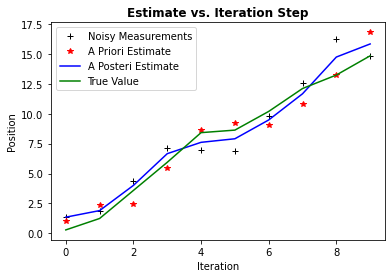

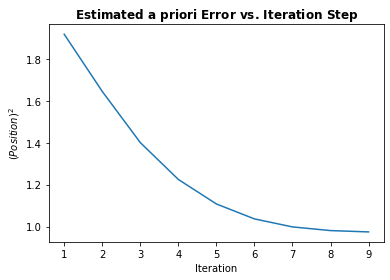

In [321]:
def plotstuff():
    plt.figure()
    plt.plot(zs,'k+',label='Noisy Measurements')
    plt.plot(x1,'r*',label='A Priori Estimate')
    plt.plot(xhat,'b-',label='A Posteri Estimate')
    plt.plot(ztrue,color='g',label='True Value')
    #plt.plot(xhat,'r*',label='prediction')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Position')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Pminus not valid at step 0
    plt.plot(valid_iter,Pminus[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

def getmeasurement(i):
    z_current = np.zeros(1)
    z_current[0] = zs[i]
    #z_current[1,0] = zsl[1,i]
    return z_current

x1 = np.zeros(n_iter)
#x2 = np.zeros(n_iter)
Pminus = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1:
    print('PREDICT\t\t\tUPDATE')
    print('     x      var\t\t  z\t    x      var')
while True:
    z = getmeasurement(counter)
    #f.z = zs #Worked without this, do I need it?
    f.predict(F=f.F, Q=f.Q)
    x1[counter] = f.x_prior[0,0]
    f.update(z,R=f.R ,H=f.H)
    xhat[counter] = f.x[0,0]
    Pminus[counter] = f.P[0,0]
    if printcase == 1:
        print_gh(f.x_prior[0,0], f.P_prior[0,0], z[0], f.x[0,0], f.P[0,0])
    counter += 1
    if (counter == (n_iter)):
        break
if printcase == 1:
    print()
    print('final estimate:        {:10.3f}'.format(f.x[0,0]))
    print('actual final position: {:10.3f}'.format(finalposition))
if plotcase == 1:
    plotstuff()